# Arctic Penguin Exploration: Unraveling Clusters in the Icy Domain with K-means clustering

![Alt text](https://imgur.com/orZWHly.png)
source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! 

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

- culmen_length_mm: culmen length (mm)
- culmen_depth_mm: culmen depth (mm)
- flipper_length_mm: flipper length (mm)
- body_mass_g: body mass (g)
- sex: penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are three species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**, so your task is to apply your data science skills to help them identify groups in the dataset!

## Project Instructions

Utilize your unsupervised learning skills to reduce dimensionality and identify clusters in the penguins dataset!

- Begin by reading in `"data/penguins.csv"` as a pandas DataFrame called `penguins_df`, then investigate and clean the dataset by removing the null values and outliers. Save as a cleaned DataFrame called `penguins_clean`.
- Pre-process the cleaned data using standard scaling and the one-hot encoding to add dummy variables:
    - Create the dummy variables and remove the original categorical feature from the dataset.
    - Scale the data using the standard scaling method.
    - Save the updated data as a new DataFrame called `penguins_preprocessed`.
- Perform Principal Component Analysis (PCA) on the `penguins_preprocessed` dataset to determine the desired number of components, considering any component with an explained variance ratio above 10% as a suitable component. Save the number of components as a variable called `n_components`.
    - Finally, execute PCA using `n_components` and store the result as `penguins_PCA`.
- Employ k-means clustering on the `penguins_PCA` dataset, setting random_state=42, to determine the number of clusters through elbow analysis. Save the optimal number of clusters in a variable called `n_cluster`.
- Create and fit a new k-means cluster model, setting `n_cluster` equal to your `n_cluster` variable, saving the model as a variable called `kmeans`.
    - Visualize your clusters using the first two principle components.
- Add the `label` column extracted from the k-means clustering (using `kmeans.labels_`) to the `penguins_clean` DataFrame.
- Create a statistical table by grouping `penguins_clean` based on the `"label"` column and calculating the `mean` of each numeric column. Save this table as `stat_penguins`.

In [173]:
# Import Required Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Loading and examining the dataset
penguins_df = pd.read_csv("data/penguins.csv")
penguins_df.head()
penguins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


In [174]:
def check_for_shape_null_na(df, title):
    '''
    This function checks the shape of the dataframe and also checks for null and na values.
    '''
    print(f'{title}: ')
    print('=========================')
    print(f'{df.shape}')
    null_na_check = pd.DataFrame({'null': df.isnull().sum(), 'na': df.isna().sum()}, columns=['null', 'na'])
    print('')
    print(null_na_check)
    print('')

In [175]:
# penguins_df.boxplot()
# plt.show()
# Begin by reading in `"data/penguins.csv"` as a pandas DataFrame called `penguins_df`, then investigate and clean the dataset by 
# removing the null values and outliers. Save as a cleaned DataFrame called `penguins_clean`.
check_for_shape_null_na(penguins_df, 'Before processing')

# Remove null values for features
#penguins_clean = penguins_df[penguins_df["sex"].notna()]
#check_for_shape_null_na(penguins_clean, 'After NaN processing')
penguins_df = penguins_df.dropna() # this way is more elegant albeit less targeted


# Remove outliers 
# ===============

# My method is using scipy.stats.zscore & we will remove all rows that have outliers 
# (more than 3 standard deviations from mean) in at least one column
# from scipy import stats
# penguins_clean = penguins_df[(np.abs(stats.zscore(penguins_df.iloc[:,:-1])) < 3).all(axis=1)]
# check_for_shape_null_na(penguins_clean, 'After NaN & outlier processing')

# outliers = pd.concat([penguins_df, penguins_clean]).drop_duplicates(keep=False)

# Solution method is to remove rows where flipper_length_mm is less than 0 or greater than 4000
# They seem to rely on manual observation in the solution for this but it does catch the -132mm outlier
# I think my method is more robust generally, but it could do with catching the negative one...
solution_condition = (penguins_df['flipper_length_mm'] > 0) | (penguins_df['flipper_length_mm'] < 4000)
penguins_clean = penguins_df[solution_condition]
solution_outliers = pd.concat([penguins_df,penguins_clean]).drop_duplicates(keep=False)

# # Remove . values for sex column
# # They don't seem to do this in the solution at this point rather later, but I think it's a good idea to remove these rows now
penguins_clean = penguins_clean[penguins_clean['sex'] != '.']
check_for_shape_null_na(penguins_clean, 'After all pre-processing')

Before processing: 
(344, 5)

                   null  na
culmen_length_mm      2   2
culmen_depth_mm       2   2
flipper_length_mm     2   2
body_mass_g           2   2
sex                   9   9

After all pre-processing: 
(334, 5)

                   null  na
culmen_length_mm      0   0
culmen_depth_mm       0   0
flipper_length_mm     0   0
body_mass_g           0   0
sex                   0   0



## Note on the above

The code above `penguins_clean[(np.abs(stats.zscore(penguins_clean)) < 3).all(axis=1)]` performs the following steps:

- `stats.zscore(penguins_clean)`: This line of code calculates the Z-score for each value in the `penguins_clean` DataFrame. The Z-score is a statistical measurement that describes a value's relationship to the mean of a group of values. It is measured in terms of standard deviations from the mean. If a Z-score is 0, it indicates that the data point's score is identical to the mean score.

- `np.abs(stats.zscore(penguins_clean))`: This line of code takes the absolute value of the Z-scores. This is done because we're interested in the magnitude of the Z-score, not its sign.

- `(np.abs(stats.zscore(penguins_clean)) < 3)`: This line of code creates a Boolean mask where each value is `True` if the corresponding Z-score is less than 3 and `False` otherwise. The number 3 is used as a threshold here because in a normal distribution, about 99.7% of values lie within 3 standard deviations of the mean. So, this condition is used to identify outliers.

- `(np.abs(stats.zscore(penguins_clean)) < 3).all(axis=1)`: This line of code reduces the 2D Boolean mask to 1D by checking if all values in a row are `True`. If all values in a row are `True`, it means that all values in that row are not outliers.

- `penguins_clean[(np.abs(stats.zscore(penguins_clean)) < 3).all(axis=1)]`: This line of code applies the Boolean mask to the `penguins_clean` DataFrame. It returns a new DataFrame that only includes the rows where all values are not outliers.

In [176]:
# Define the transformations we require for the features
penguins_preprocessed_categorical = pd.get_dummies(penguins_clean[['sex']])
penguins_preprocessed = pd.concat([penguins_preprocessed_categorical.iloc[:, 0], penguins_clean.iloc[:,:-1]], axis=1)
print(penguins_preprocessed.head())

# Scale the data using the standard scaling method.
# Should really split data before we scale it, 
# but we need to end up with a single dataframe called penguins_preprocessed!
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# force output to stay a dataframe
penguins_preprocessed = pd.DataFrame(sc.fit_transform(penguins_preprocessed), columns=penguins_preprocessed.columns) 
# # Check results
print(penguins_preprocessed.head())

   sex_FEMALE  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0       False              39.1             18.7              181.0   
1        True              39.5             17.4              186.0   
2        True              40.3             18.0              195.0   
4        True              36.7             19.3              193.0   
5       False              39.3             20.6              190.0   

   body_mass_g  
0       3750.0  
1       3800.0  
2       3250.0  
4       3450.0  
5       3650.0  
   sex_FEMALE  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0   -0.988095         -0.896113         0.774517          -0.126674   
1    1.012049         -0.822764         0.114726          -0.107681   
2    1.012049         -0.676065         0.419245          -0.073493   
3    1.012049         -1.336209         1.079036          -0.081090   
4   -0.988095         -0.859439         1.738827          -0.092486   

   body_mass_g  
0    -0.569485  
1    -0.50

Number of components: 3
Solution is interestingly n-components=4 so will go with that as it is borderline


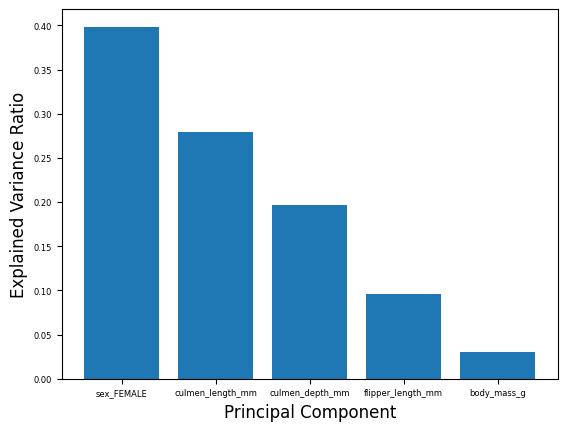

<Figure size 1200x800 with 0 Axes>

In [177]:
# -  to determine the desired number
# of components, considering any component with an explained variance ratio above 10% as a suitable component. 
# Save the number of components as a variable called `n_components`.

# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=None)

# Perform Principal Component Analysis (PCA) on the features
pca.fit(penguins_preprocessed)
exp_variance = pca.explained_variance_ratio_
# plot the explained variance ratios using a barplot
fig, ax = plt.subplots()
plt.figure(figsize=(12, 8))
plt.rcParams['font.size'] = 6
ax.bar(penguins_preprocessed.columns.tolist(), exp_variance)
ax.set_ylabel('Explained Variance Ratio', fontsize=12)
ax.set_xlabel('Principal Component', fontsize=12)

# calculate the number of features with > 10% explained variance
n_components = sum([1 if x > 0.1 else 0 for x in exp_variance])
print(f'Number of components: {n_components}')
print('Solution is interestingly n-components=4 so will go with that as it is borderline')
n_components = 4

pca = PCA(n_components=n_components)
penguins_PCA = pca.fit_transform(penguins_preprocessed)

/Users/n18576/source/edoatley/ml/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/n18576/source/edoatley/ml/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/n18576/source/edoatley/ml/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/n18576/source/edoatley/ml/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416:

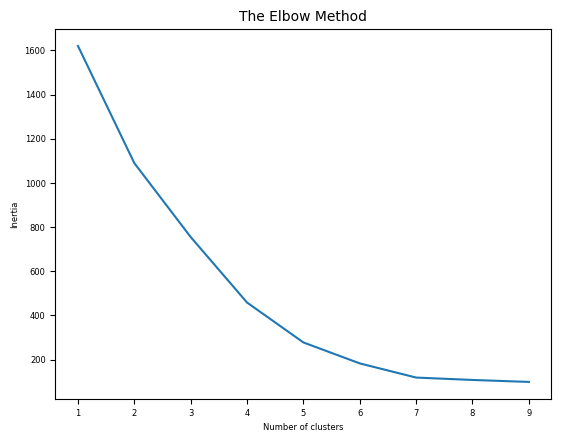

In [178]:
# Employ k-means clustering on the `penguins_PCA` dataset, setting random_state=42,
# to determine the number of clusters through elbow analysis. 
# Save the optimal number of clusters in a variable called `n_cluster`.
from sklearn.cluster import KMeans
inertia = []
for i in range(1,10):
    kmeans = KMeans(n_clusters = i, random_state = 42).fit(penguins_PCA)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

/Users/n18576/source/edoatley/ml/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


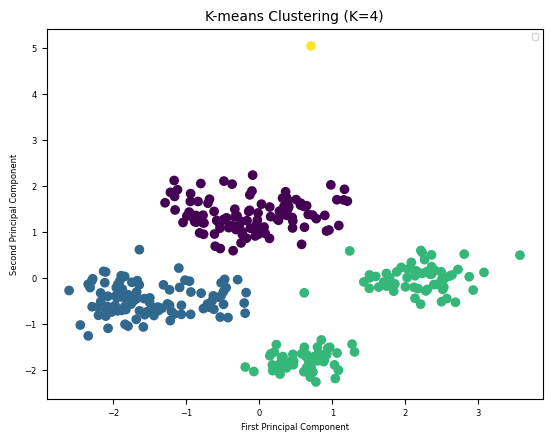

In [179]:
# from the graph I would say the elbow method gives 5 as the optimal number of clusters
# n_clusters = 5
# The solution disagrees and says 4
# from the graph that follows the fifth is there but appears an outlier
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(penguins_PCA)
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'K-means Clustering (K={n_clusters})')
plt.legend()
plt.show()



In [180]:
# - Add the `label` column extracted from the k-means clustering (using `kmeans.labels_`) to 
#   the `penguins_clean` DataFrame.
penguins_clean['label'] = kmeans.labels_
# - Create a statistical table by grouping `penguins_clean` based on the `"label"` column and 
#   calculating the `mean` of each numeric column. Save this table as `stat_penguins`.
#print(penguins_clean.head())
stat_penguins = penguins_clean.groupby('label').mean(numeric_only=True)
print(stat_penguins)

       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
label                                                                   
0             43.791589        19.129907         191.710280  4010.280374
1             40.050000        17.609434         189.122642  3416.509434
2             47.655000        15.020000         216.933333  5080.833333
3             42.000000        20.200000        5000.000000  4250.000000
